# Rolling Planning mit Flow Time

In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.lp import flowtime_scheduling as lp_ft_schedule
from src.models.lp import flowtime_rescheduling as lp_ft_reschedule

# Simulation
from src.simulation.ProductionDaySimulation import ProductionDaySimulation

# Extern
import pandas as pd
pd.set_option('display.min_rows', 16)
pd.set_option('display.max_rows', 21)

In [2]:
max_time = 60*15

## Laden der Initialisierungsdaten

In [3]:
data_path = get_path("data", "lp_flowtime")

In [4]:
df_jssp = pd.read_csv(data_path / "02_flowtime_all_jssp.csv")
df_times = pd.read_csv(data_path / "02_flowtime_all_times.csv")
df_times 

,Job,Production_Plan_ID,Arrival
0,0,0,51
1,1,1,136
2,2,2,158
3,3,3,236
4,4,4,404
5,5,5,485
6,6,6,501
7,7,7,528
...,...,...,...
81,81,0,6565


### Tag 0 

In [5]:
df_schedule = pd.read_csv(data_path / "02_flowtime_init_schedule.csv")
df_schedule

,Job,Production_Plan_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,0,0,0,51,M00,51.0,29.0,29.0,80.0
1,0,0,1,51,M01,80.0,78.0,107.0,158.0
2,0,0,2,51,M02,158.0,9.0,116.0,167.0
3,0,0,3,51,M03,167.0,36.0,152.0,203.0
4,0,0,4,51,M04,203.0,49.0,201.0,252.0
5,0,0,5,51,M05,252.0,11.0,212.0,263.0
6,0,0,6,51,M06,263.0,62.0,274.0,325.0
7,0,0,7,51,M07,325.0,56.0,330.0,381.0
...,...,...,...,...,...,...,...,...,...
172,9,9,2,559,M02,697.0,61.0,199.0,758.0


In [6]:
df_execution = pd.read_csv(data_path / "02_flowtime_execution.csv")
df_execution 

,Job,Production_Plan_ID,Operation,Machine,Arrival,Start,Processing Time,End
0,0,0,0,M00,51,51.00,41.37,92.37
1,0,0,1,M01,51,92.37,77.24,169.61
2,0,0,2,M02,51,169.61,9.65,179.26
3,0,0,3,M03,51,179.26,39.85,219.11
4,0,0,4,M04,51,219.11,60.68,279.79
5,0,0,5,M05,51,279.79,9.13,288.92
6,0,0,6,M06,51,288.92,80.00,368.92
7,0,0,7,M07,51,368.92,49.26,418.18
...,...,...,...,...,...,...,...,...
120,9,9,2,M02,559,740.01,47.53,787.54


In [7]:
df_undone = pd.read_csv(data_path / "02_flowtime_init_undone.csv")
df_undone

,Job,Production_Plan_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,10,0,5,963,M05,1199.0,11.0,247.0,1210.0
1,10,0,6,963,M06,1210.0,62.0,309.0,1272.0
2,10,0,7,963,M07,1272.0,56.0,365.0,1328.0
3,10,0,8,963,M08,1369.0,44.0,450.0,1413.0
4,10,0,9,963,M09,1470.0,21.0,528.0,1491.0
5,11,9,6,969,M05,1470.0,47.0,548.0,1517.0
6,11,9,7,969,M03,1517.0,52.0,600.0,1569.0
7,11,9,8,969,M04,1607.0,90.0,728.0,1697.0
...,...,...,...,...,...,...,...,...,...
44,17,3,2,1343,M00,1636.0,71.0,364.0,1707.0


### Settings

In [8]:
def get_schedule_filename(prefix: str = "", day: int = 0, data_txt: str = "schedule", suffix: str = "") -> str:
    file_template = "{prefix}_{data}_{day:02d}{suffix}.csv"
    if suffix:
        suffix = f"_{suffix}"
    return data_path / file_template.format(prefix=prefix,data=data_txt,day=day, suffix=suffix)

## Params

In [9]:
# fix
day_length = 1440

notebook_prefix = "3b"

#### Rescheduling für Tage 1-5

#### Rescheduling für Tage 1-5
- Tag 1: Ankunfttermine am Tag 1 + unabgeschlosse von Vortagen (evtl. Tag 0)
- Tag 2: Ankunfttermine am Tag 2 + unabgeschlosse von Vortagen (evtl. Tag 0 "oder" Tag 1)
- ...
- Tag 5: Ankunfttermine in Tag 5 + unabgeschlosse von Vortagen

In [10]:
first_start = 1
last_planning_start = 5


Day 01: [1440, 2880)
[INFO] Jobs zwischen 1440 und 2880: 22 Jobs gefunden.
[INFO] 52 zusätzliche Operationen hinzugefügt (gesamt: 272).
[INFO] 7 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.
BigM: 16000

Solver-Informationen:
  Zielfunktionswert       : 17489.5
  Solver-Status           : Optimal
  Anzahl Variablen        : 4076
  Anzahl Constraints      : 7850
  Laufzeit                : ~900.64 Sekunden


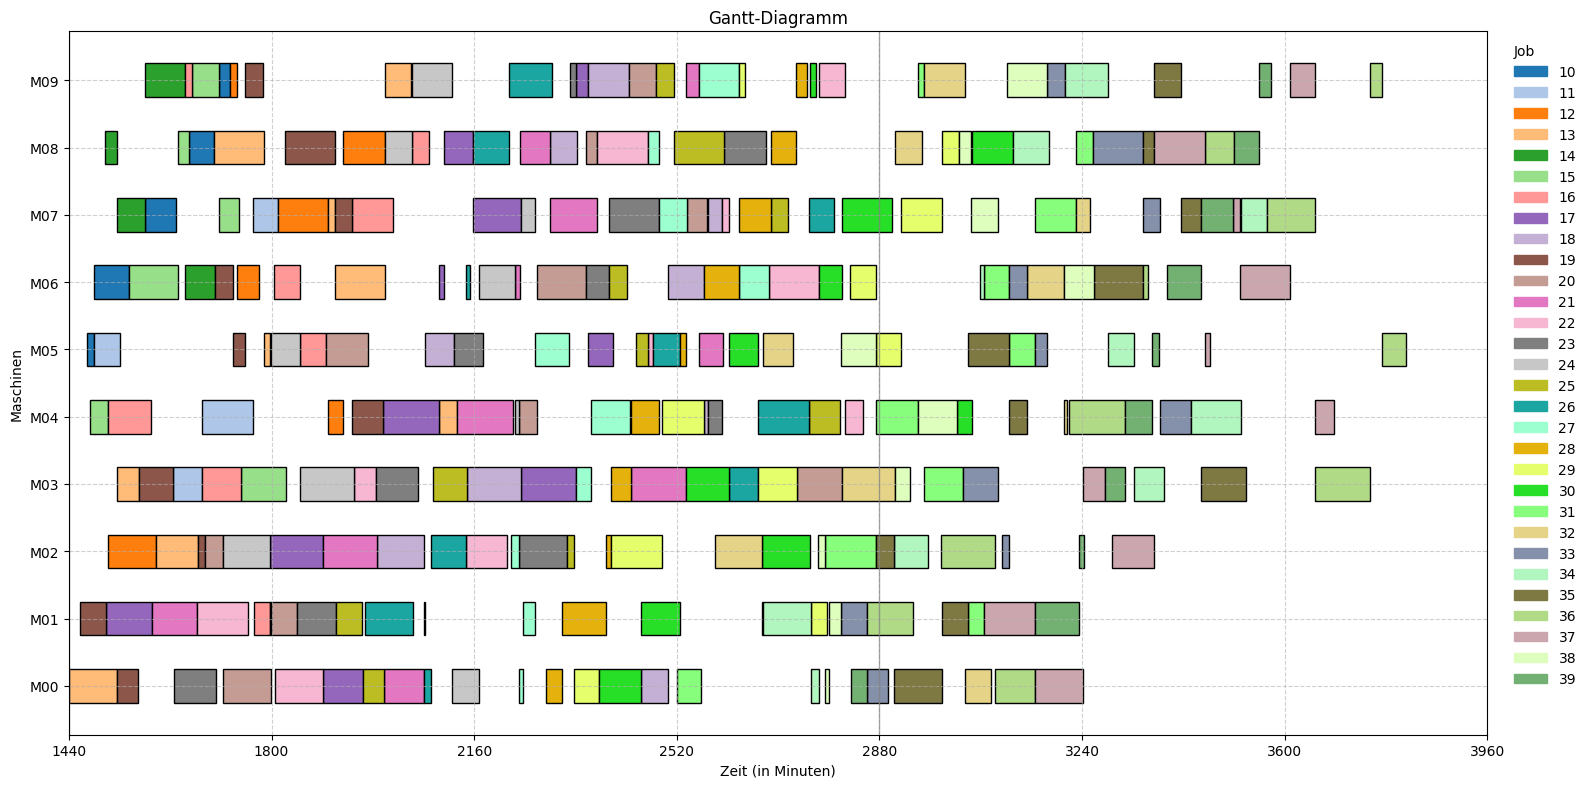

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

[24:00:00] Job 13 started on M00
[24:20:00] Job 19 started on M01
[24:33:00] Job 10 started on M05
[24:38:00] Job 15 started on M04
[24:46:32] Job 10 finished on M05 (after 13 minutes 33 seconds)
[24:46:32] Job 11 started on M05
[24:46:32] Job 10 started on M06
[24:55:48] Job 13 finished on M00 (after 55 minutes 49 seconds)
[25:05:00] Job 14 started on M08
[25:10:00] Job 12 started on M02
[25:11:55] Job 19 finished on M01 (after 51 minutes 56 seconds)
[25:11:55] Job 17 started on M01
[25:13:20] Job 15 finished on M04 (after 35 minutes 21 seconds)
[25:13:20] Job 16 started on M04
[25:25:00] Job 13 started on M03
[25:25:00] Job 19 started on M00
[25:27:56] Job 14 finished on M08 (after 22 minutes 56 seconds)
[25:27:56] Job 14 started on M0

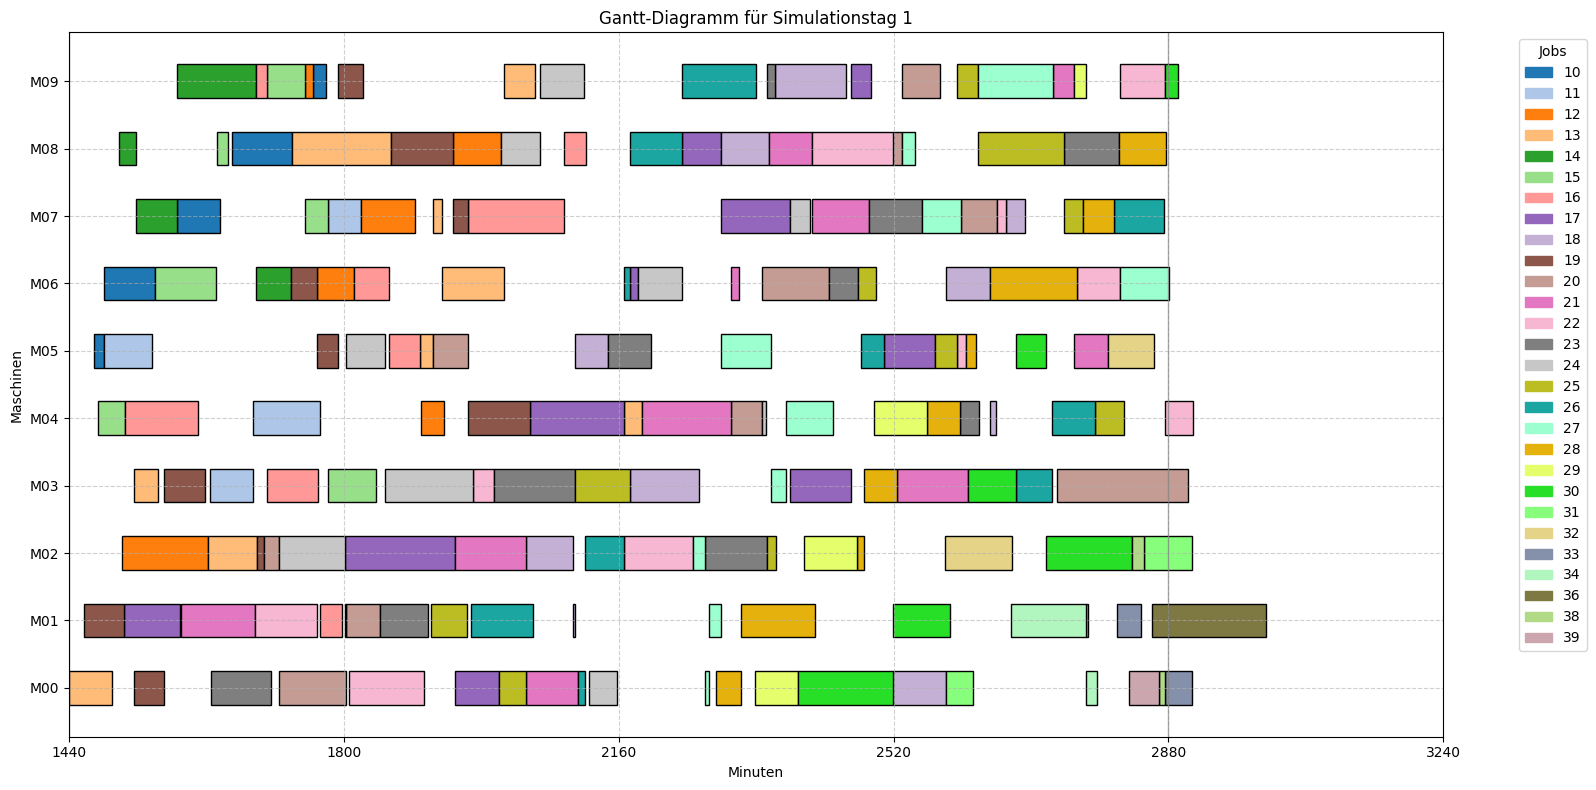


Day 02: [2880, 4320)
[INFO] Jobs zwischen 2880 und 4320: 16 Jobs gefunden.
[INFO] 88 zusätzliche Operationen hinzugefügt (gesamt: 248).
[INFO] 7 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.
BigM: 15000

Solver-Informationen:
  Zielfunktionswert       : 21818.1
  Solver-Status           : Optimal
  Anzahl Variablen        : 3513
  Anzahl Constraints      : 6750
  Laufzeit                : ~900.87 Sekunden


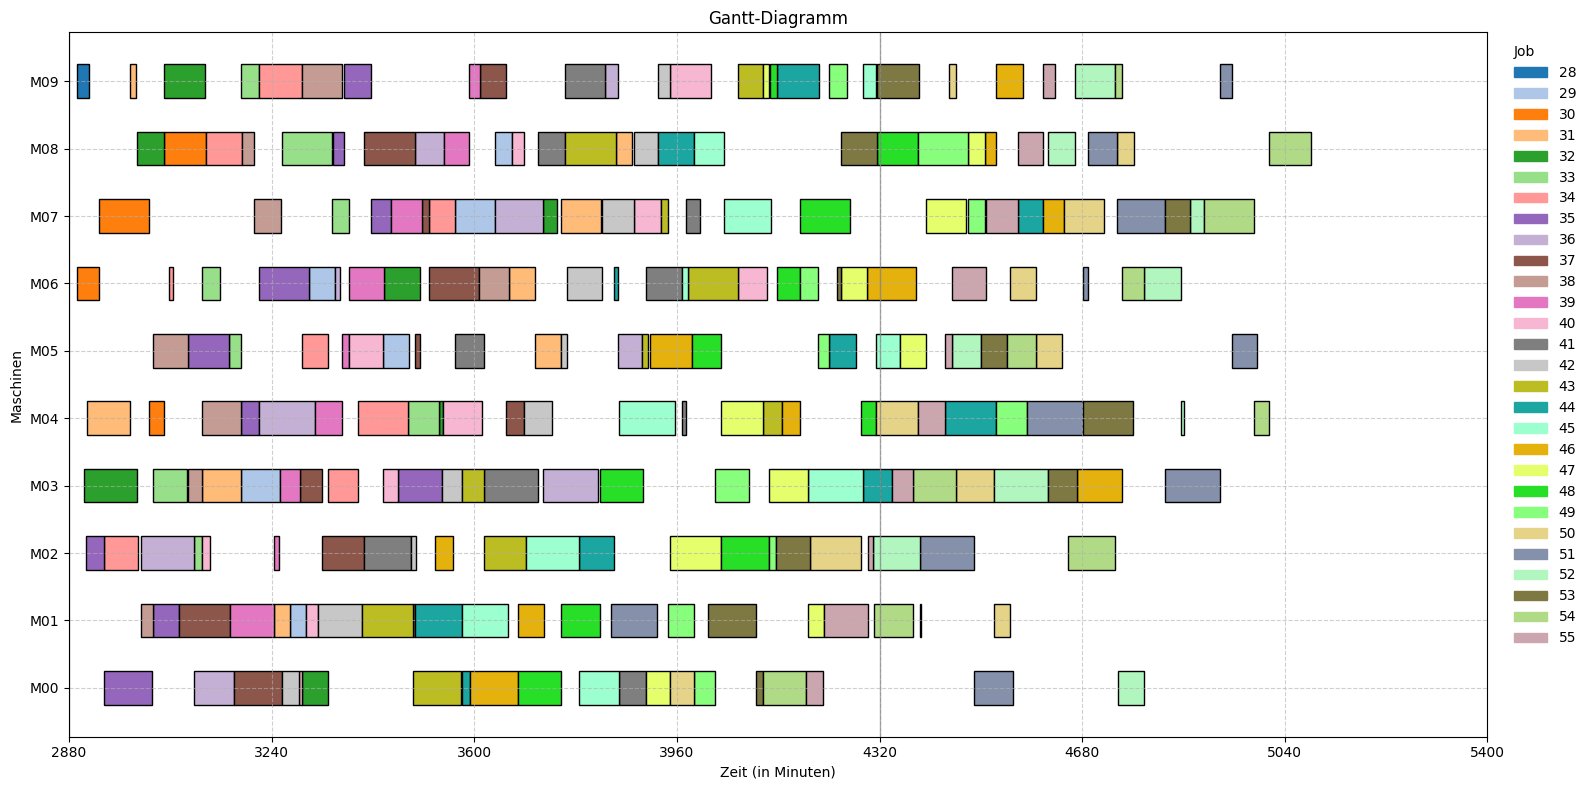

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

[48:14:00] Job 28 started on M09
[48:14:00] Job 30 started on M06
[48:26:00] Job 32 started on M03
[48:31:00] Job 35 started on M02
[48:33:00] Job 31 started on M04
[48:34:09] Job 28 finished on M09 (after 20 minutes 09 seconds)
[48:53:43] Job 30 finished on M06 (after 39 minutes 43 seconds)
[48:54:00] Job 30 started on M07
[48:58:09] Job 35 finished on M02 (after 27 minutes 09 seconds)
[49:02:00] Job 34 started on M02
[49:02:00] Job 35 started on M00
[49:35:32] Job 31 finished on M04 (after 62 minutes 32 seconds)
[49:48:00] Job 31 started on M09
[49:53:52] Job 34 finished on M02 (after 51 minutes 53 seconds)
[49:54:13] Job 31 finished on M09 (after 06 minutes 14 seconds)
[50:08:00] Job 36 started on M02
[50:08:00] Job 38 started on M01


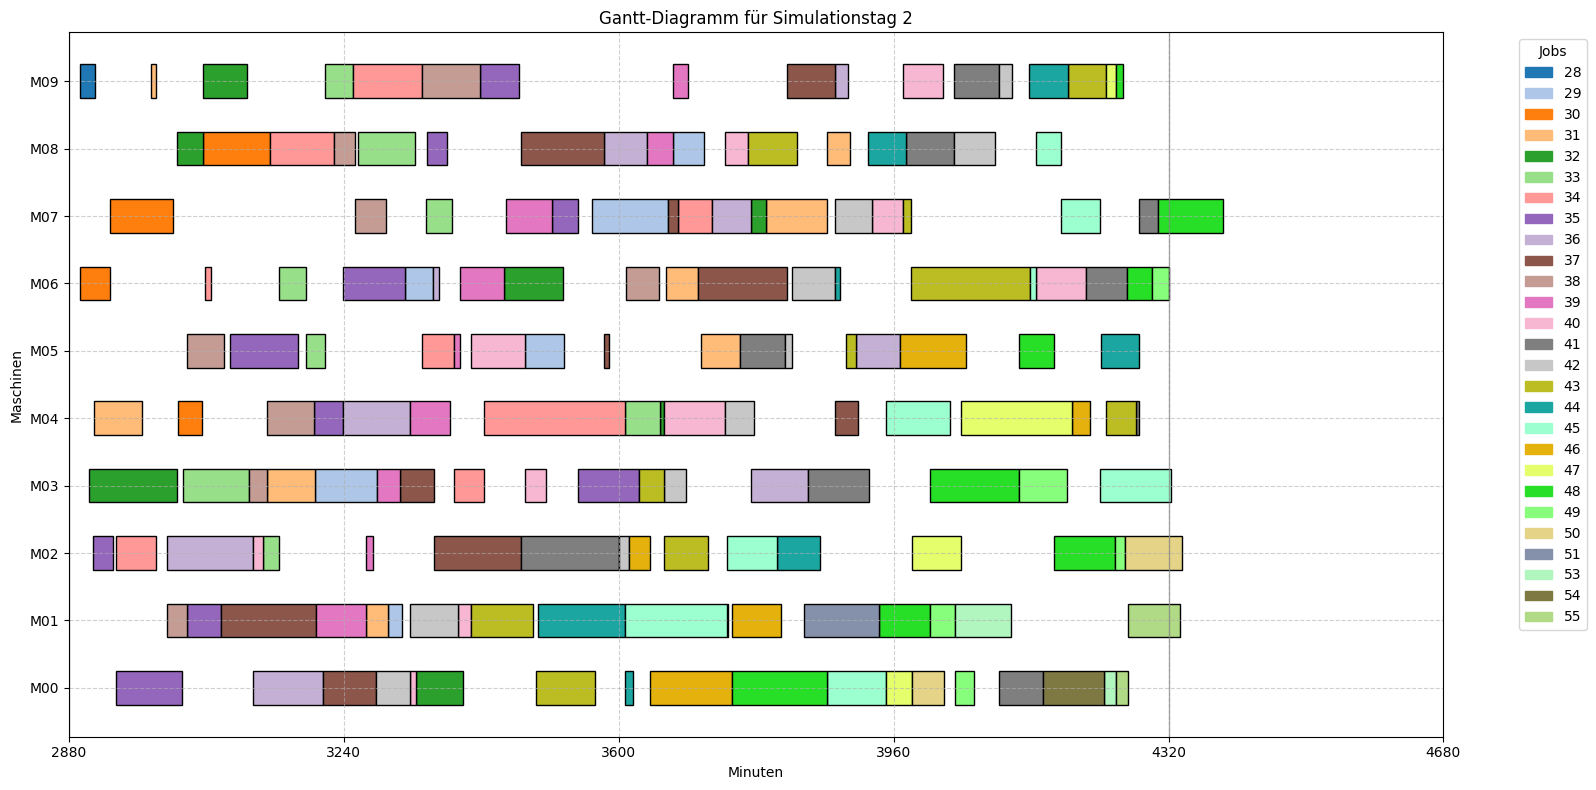


Day 03: [4320, 5760)
[INFO] Jobs zwischen 4320 und 5760: 15 Jobs gefunden.
[INFO] 75 zusätzliche Operationen hinzugefügt (gesamt: 225).
[INFO] 5 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.
BigM: 14000

Solver-Informationen:
  Zielfunktionswert       : 18114.1
  Solver-Status           : Optimal
  Anzahl Variablen        : 2892
  Anzahl Constraints      : 5532
  Laufzeit                : ~900.66 Sekunden


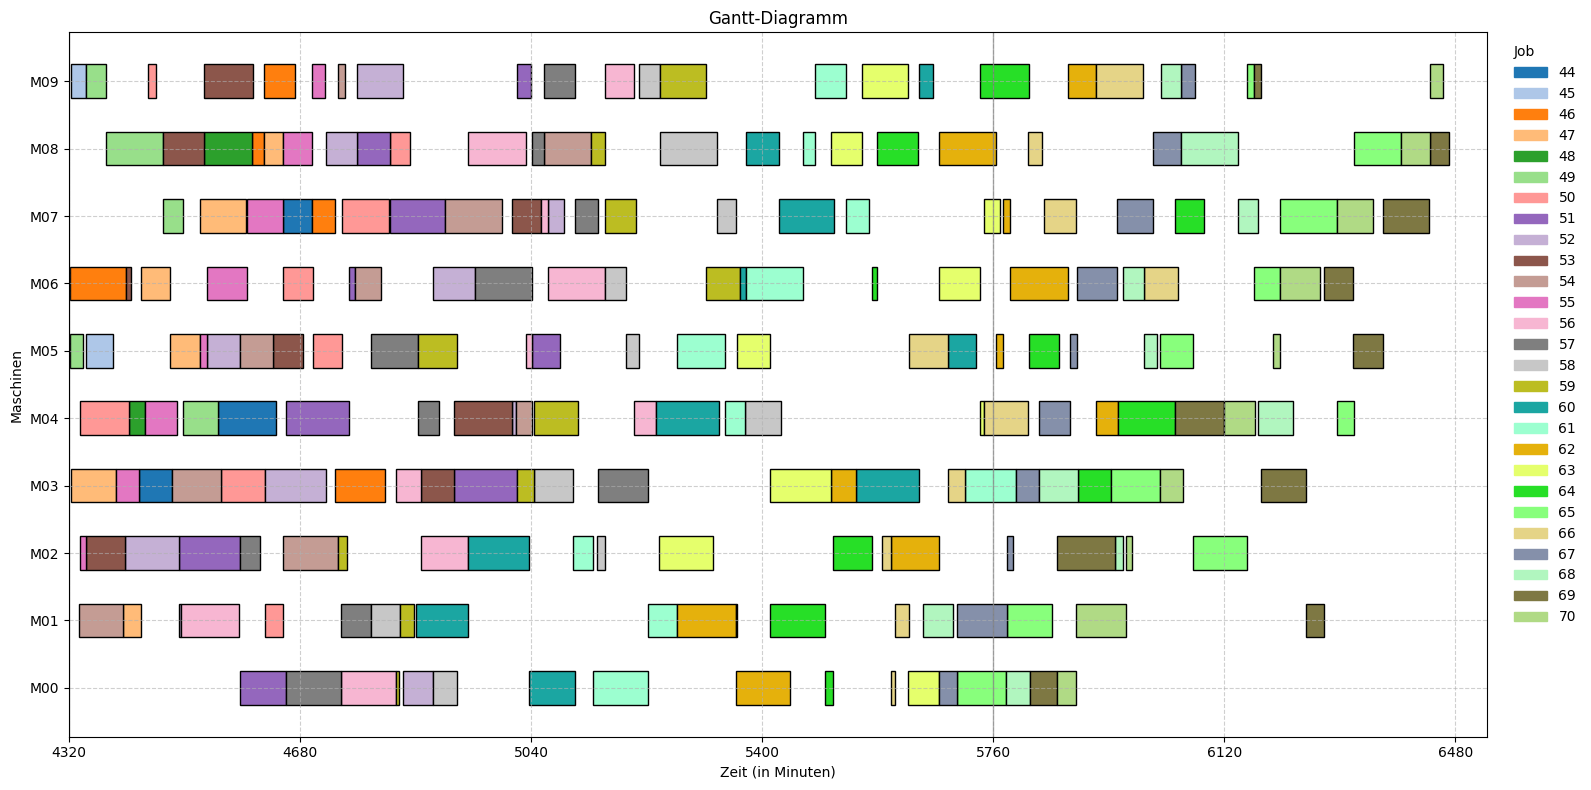

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

[72:01:00] Job 46 started on M06
[72:01:00] Job 49 started on M05
[72:04:00] Job 45 started on M09
[72:04:00] Job 47 started on M03
[72:15:00] Job 54 started on M01
[72:18:00] Job 50 started on M04
[72:18:00] Job 55 started on M02
[72:25:55] Job 55 finished on M02 (after 07 minutes 55 seconds)
[72:27:00] Job 53 started on M02
[72:35:36] Job 45 finished on M09 (after 31 minutes 37 seconds)
[72:43:27] Job 49 finished on M05 (after 42 minutes 28 seconds)
[72:43:27] Job 45 started on M05
[72:43:27] Job 49 started on M09
[73:05:36] Job 49 finished on M09 (after 22 minutes 08 seconds)
[73:05:36] Job 49 started on M08
[73:14:43] Job 50 finished on M04 (after 56 minutes 44 seconds)
[73:25:03] Job 54 finished on M01 (after 70 minutes 03 seconds)


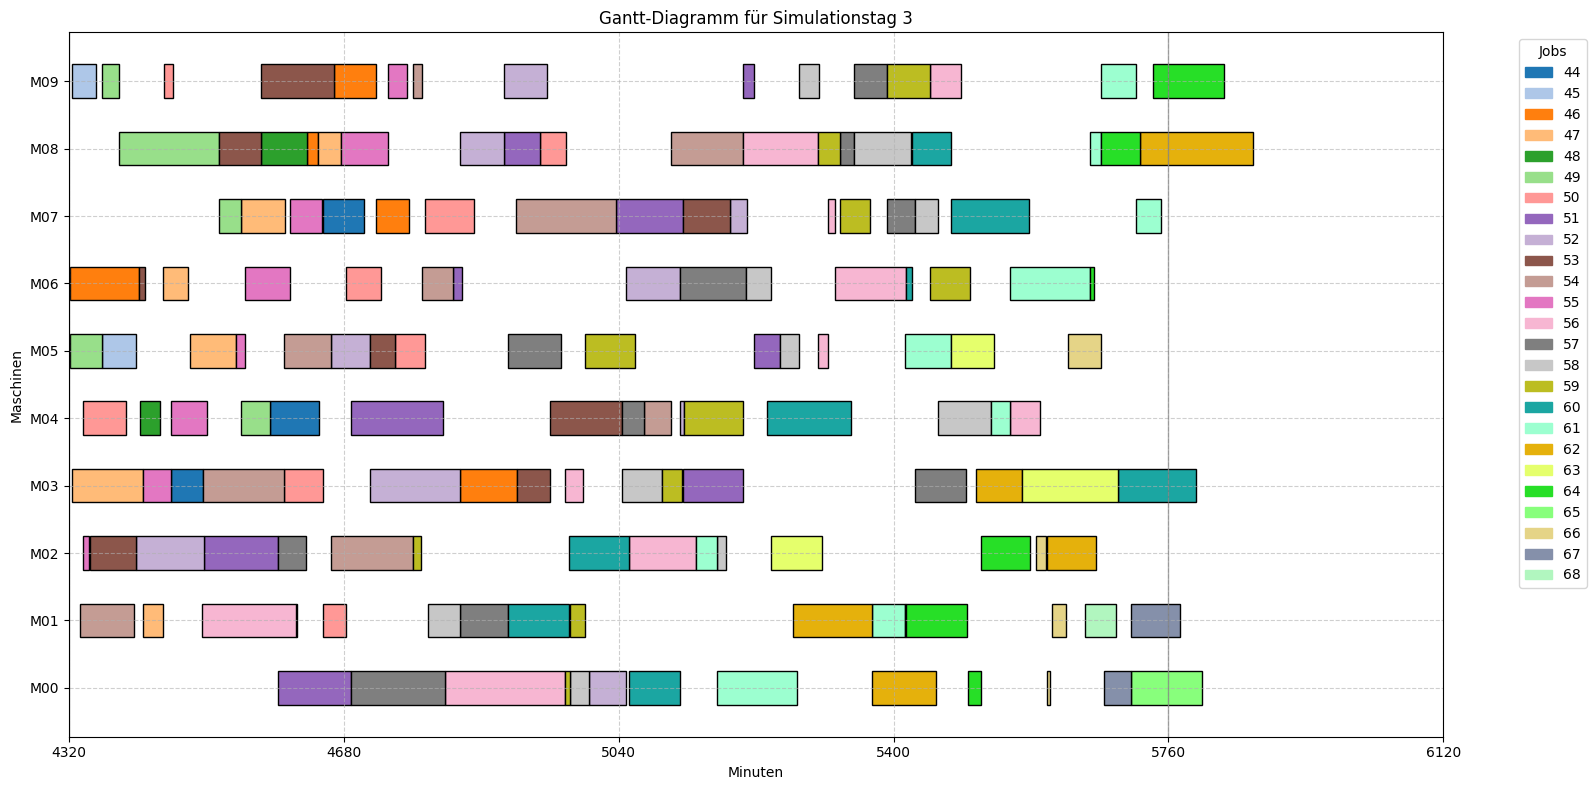


Day 04: [5760, 7200)
[INFO] Jobs zwischen 5760 und 7200: 18 Jobs gefunden.
[INFO] 70 zusätzliche Operationen hinzugefügt (gesamt: 250).
[INFO] 5 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.
BigM: 15000

Solver-Informationen:
  Zielfunktionswert       : 20669.4
  Solver-Status           : Optimal
  Anzahl Variablen        : 3492
  Anzahl Constraints      : 6705
  Laufzeit                : ~901.40 Sekunden


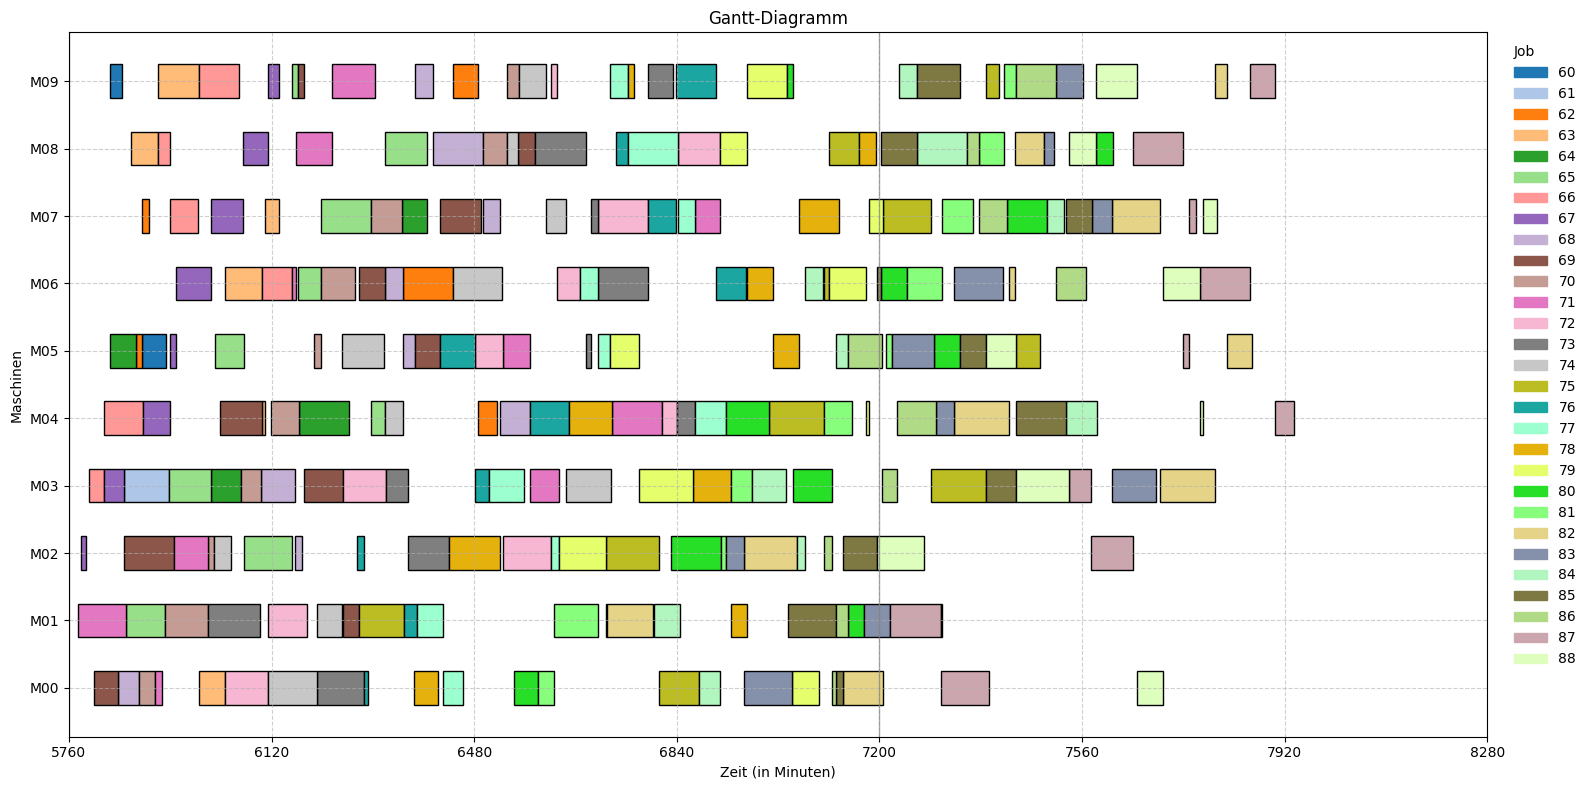

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

[96:16:00] Job 71 started on M01
[96:22:00] Job 67 started on M02
[96:32:54] Job 67 finished on M02 (after 10 minutes 55 seconds)
[96:36:00] Job 66 started on M03
[96:44:00] Job 69 started on M00
[96:54:33] Job 66 finished on M03 (after 18 minutes 34 seconds)
[97:02:00] Job 67 started on M03
[97:02:00] Job 66 started on M04
[97:11:29] Job 71 finished on M01 (after 55 minutes 29 seconds)
[97:13:00] Job 60 started on M09
[97:13:00] Job 64 started on M05
[97:26:22] Job 69 finished on M00 (after 42 minutes 22 seconds)
[97:27:00] Job 68 started on M00
[97:33:02] Job 67 finished on M03 (after 31 minutes 02 seconds)
[97:37:00] Job 69 started on M02
[97:38:00] Job 61 started on M03
[97:39:53] Job 60 finished on M09 (after 26 minutes 53 seconds)


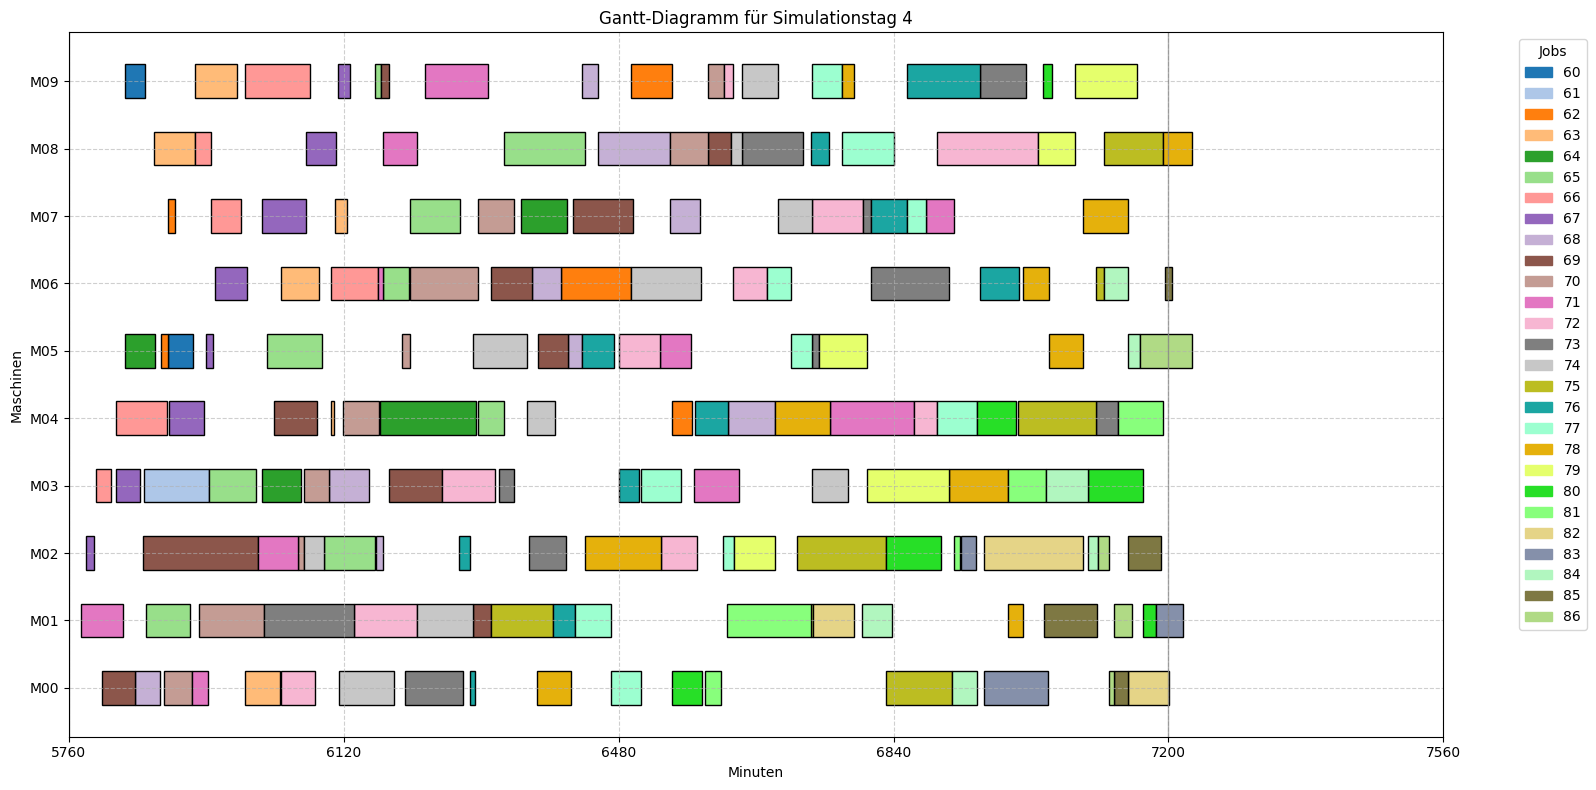


Day 05: [7200, 8640)
[INFO] Jobs zwischen 7200 und 8640: 0 Jobs gefunden.
[INFO] 67 zusätzliche Operationen hinzugefügt (gesamt: 67).
[INFO] 5 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.
BigM: 5000

Solver-Informationen:
  Zielfunktionswert       : 7701.6
  Solver-Status           : Optimal
  Anzahl Variablen        : 412
  Anzahl Constraints      : 746
  Laufzeit                : ~139.54 Sekunden


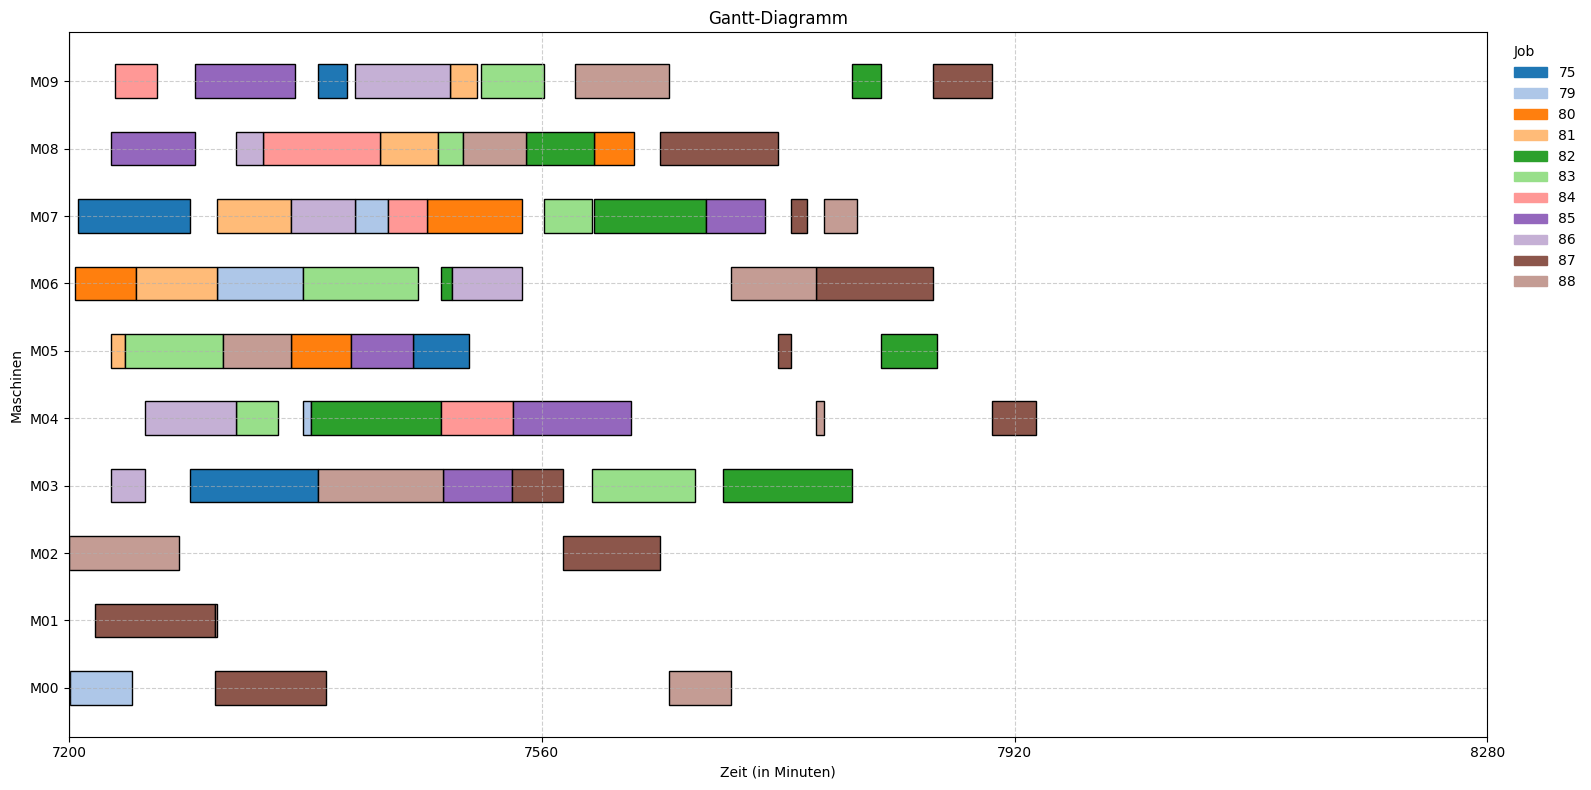

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

[120:00:00] Job 88 started on M02
[120:01:00] Job 79 started on M00
[120:05:00] Job 80 started on M06
[120:07:00] Job 75 started on M07
[120:20:00] Job 87 started on M01
[120:32:00] Job 81 started on M05
[120:32:00] Job 85 started on M08
[120:32:00] Job 86 started on M03
[120:35:00] Job 84 started on M09
[120:40:17] Job 88 finished on M02 (after 40 minutes 17 seconds)
[120:41:11] Job 81 finished on M05 (after 09 minutes 11 seconds)
[120:43:00] Job 83 started on M05
[120:43:55] Job 79 finished on M00 (after 42 minutes 56 seconds)
[120:53:10] Job 80 finished on M06 (after 48 minutes 10 seconds)
[120:53:10] Job 81 started on M06
[120:56:36] Job 84 finished on M09 (after 21 minutes 37 seconds)
[121:06:50] Job 86 finished on M03 (after 34 min

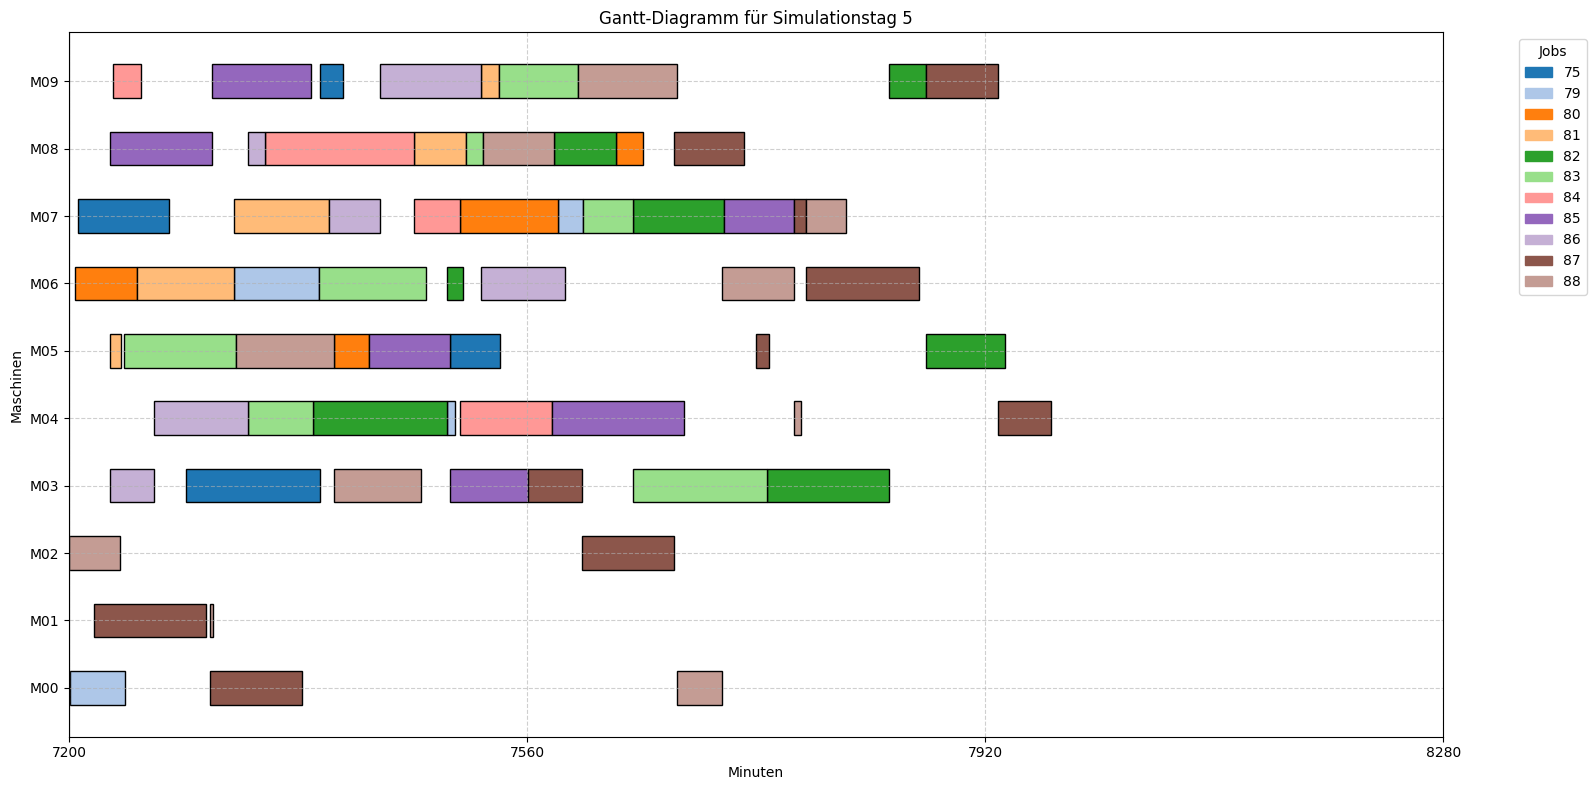

In [11]:
for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length * day_numb
    day_end = day_start + day_length
    print(f"\nDay {day_numb:02d}: [{day_start}, {day_end})")

    # ------------------- I. Ankunfts- und Operationsvorbereitung -------------------
    df_jssp_curr, df_times_curr = process_filter.jobs_by_arrival_window(df_times, df_jssp, day_start, day_end, verbose= True)

    
    df_jssp_curr = process_filter.extend_with_undone_operations(df_jssp_curr, df_undone, verbose= True)
    df_times_curr = process_filter.update_times_after_operation_changes(df_times, df_jssp_curr)

    # ------------------- II. Relevante laufende Operationen -------------------------
    df_execution_important = process_filter.get_operations_running_into_day(df_execution, day_start, verbose= True)

    # ------------------- III. Rescheduling durchführen -------------------------------
    df_schedule = lp_ft_reschedule.solve_jssp_with_devpen(df_jssp_curr, df_times_curr, 
                                                                   df_execution_important, df_original_plan = df_schedule,
                                                                   r = 0.70, # 70% Flowtime, 30% Abweichung
                                                                   reschedule_start = day_start, solver= "HiGHS", 
                                                                   msg=False, timeLimit=max_time, gapRel= 0.02)

    
    df_schedule.to_csv(get_schedule_filename(notebook_prefix, day=day_numb), index=False)

    show.plot_gantt(df_schedule, perspective="Machine")
    check.all_in_one(df_schedule)

    # ------------------- IV. Einen Tag simulieren -------------------------------------

    simulation = ProductionDaySimulation(df_schedule, vc=0.25)
    df_execution = simulation.run(start_time=day_start, end_time=day_end)
    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}")
    else:
        print(f"Nothing executed on day {day_numb}")

    df_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
    
